In [2]:
from datasets import load_dataset
from PIL import Image

/Users/aldofebri/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
datasets = load_dataset("katanaml/cord", split='test')
datasets[0]

Repo card metadata block was not found. Setting CardData to empty.


{'id': '0',
 'words': ['TAX',
  '5.455',
  'TOTAL',
  '60.000',
  '(Qty',
  '2.00',
  'EDC',
  'CIMB',
  'NIAGA',
  'No:',
  'xx7730',
  '60.000',
  '901016',
  '-TICKET',
  'CP',
  '2',
  '60.000',
  '60.000',
  'Subtotal',
  '60.000',
  'TOTAL',
  'DISC',
  '$',
  '-60.000'],
 'bboxes': [[490, 743, 555, 774],
  [722, 746, 819, 777],
  [101, 827, 282, 858],
  [648, 820, 851, 856],
  [314, 820, 444, 856],
  [479, 822, 615, 851],
  [138, 904, 203, 938],
  [208, 904, 287, 935],
  [291, 901, 388, 935],
  [393, 901, 453, 932],
  [458, 898, 578, 929],
  [731, 901, 847, 932],
  [97, 604, 212, 635],
  [337, 595, 462, 626],
  [467, 595, 513, 626],
  [208, 641, 231, 669],
  [402, 632, 518, 663],
  [703, 632, 814, 663],
  [407, 783, 550, 814],
  [708, 783, 824, 817],
  [337, 709, 435, 740],
  [435, 709, 520, 736],
  [523, 709, 550, 734],
  [687, 709, 819, 737]],
 'ner_tags': [14,
  14,
  22,
  22,
  19,
  19,
  17,
  17,
  17,
  17,
  17,
  17,
  4,
  3,
  3,
  1,
  5,
  0,
  13,
  13,
  10,
  1

In [5]:
import torch
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
model = LayoutLMv2ForTokenClassification.from_pretrained("katanaml/layoutlmv2-finetuned-cord")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [15]:
import numpy as np
expected_list = []
predicted_list = []
for data in datasets:
    image_file = data['image_path'].split("image/")[-1]
    # image_file = 'receipt_00012.png'
    print(image_file)
    image = Image.open("image/" + image_file)
    words = data['words']
    bbox = data['bboxes']
    encoded_inputs = processor(image, words, boxes=bbox, return_offsets_mapping=True, return_tensors="pt")

    offset_mapping = encoded_inputs.pop('offset_mapping')
    for k,v in encoded_inputs.items():
        encoded_inputs[k] = v.to(device)
    # load the fine-tuned model from the hub
    id2label = model.config.id2label
    model.to(device)

    # forward pass
    outputs = model(**encoded_inputs)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [pred for idx, pred in enumerate(predictions) if not is_subword[idx]][1:-1]
    expected = data['ner_tags']
    if len(expected) != len(true_predictions):
        continue
    else:
        expected_list.extend(expected)
        predicted_list.extend(true_predictions)

receipt_00000.png
receipt_00001.png
receipt_00002.png
receipt_00003.png
receipt_00004.png
receipt_00005.png
receipt_00006.png
receipt_00007.png
receipt_00008.png
receipt_00009.png
receipt_00010.png
receipt_00011.png
receipt_00012.png
receipt_00013.png
receipt_00014.png
receipt_00015.png
receipt_00016.png
receipt_00017.png
receipt_00018.png
receipt_00019.png
receipt_00020.png
receipt_00021.png
receipt_00022.png
receipt_00023.png
receipt_00024.png
receipt_00025.png
receipt_00026.png
receipt_00027.png
receipt_00028.png
receipt_00029.png
receipt_00030.png
receipt_00031.png
receipt_00032.png
receipt_00033.png
receipt_00034.png
receipt_00035.png
receipt_00036.png
receipt_00037.png
receipt_00038.png
receipt_00039.png
receipt_00040.png
receipt_00041.png
receipt_00042.png
receipt_00043.png
receipt_00044.png
receipt_00045.png
receipt_00046.png
receipt_00047.png
receipt_00048.png
receipt_00049.png
receipt_00050.png
receipt_00051.png
receipt_00052.png
receipt_00053.png
receipt_00054.png
receipt_00

In [207]:
print(len(expected_list), len(predicted_list))

2299 2299


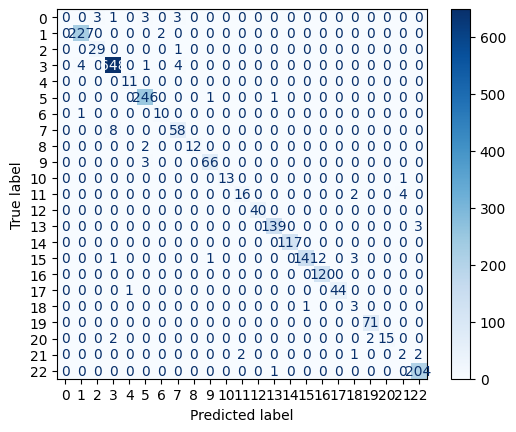

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt;
import pandas as pd
conf_matrix = confusion_matrix(expected_list, predicted_list)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
#Save CF
# Convert to DataFrame for better visualization
df_cm = pd.DataFrame(conf_matrix, index=[f"Actual {i}" for i in range(conf_matrix.shape[0])],
                     columns=[f"Predicted {i}" for i in range(conf_matrix.shape[1])])

# Save to Excel file
df_cm.to_excel("confusion_matrix.xlsx", index=True)

TP, FP, FN, TN = [], [], [], []

for i in range(len(conf_matrix)):
    tp = conf_matrix[i, i]
    TP.append(tp)
    
    fp = conf_matrix[:, i].sum() - tp
    FP.append(fp)
    
    fn = conf_matrix[i, :].sum() - tp
    FN.append(fn)
    
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - tp)
    TN.append(tn)

df = pd.DataFrame({
    'Class': [f'Class {i+0}' for i in range(len(conf_matrix))],
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN
})

# Save the DataFrame to an Excel file
df.to_excel('confusion_matrix_results.xlsx', index=False)

In [49]:
def sum_all(result: list):
    sum = 0
    for number in list:
        sum+=number
    return sum

def calculate_accuracy(tp, fp, fn, tn):
    return (tp + tn) / (tp + fp + fn + tn)

def calculate_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def calculate_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

sum_tp = sum(TP)
sum_fp = sum(FP)
sum_fn = sum(FN)
sum_tn = sum(TN)

acc = calculate_accuracy(sum_tp, sum_fp, sum_fn, sum_tn)
prec = calculate_precision(sum_tp, sum_fp)
recall = calculate_recall(sum_tp, sum_fn)
f1 = calculate_f1(prec, recall)
print(acc, prec, recall, f1)

0.9974658168958148 0.9708568943018704 0.9708568943018704 0.9708568943018704
